# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.360359,False,2.576930
1,1.694849,True,7.311721
2,1.241285,True,5.746840
3,1.394706,True,3.917642
4,-0.724665,False,-0.445722
...,...,...,...
995,0.340596,False,-0.440617
996,-1.250012,True,6.344027
997,0.895968,False,-0.855862
998,-0.161019,False,-0.490099


<Axes: xlabel='v0'>

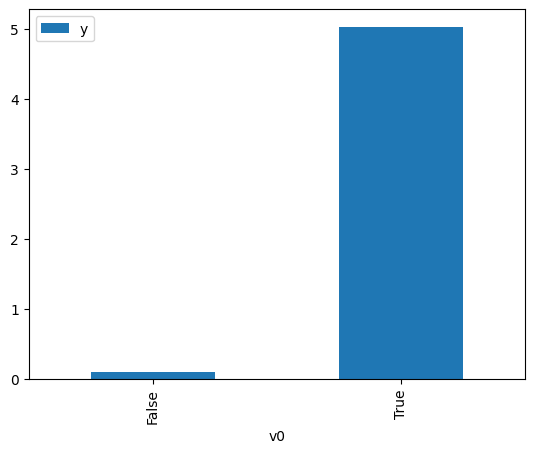

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

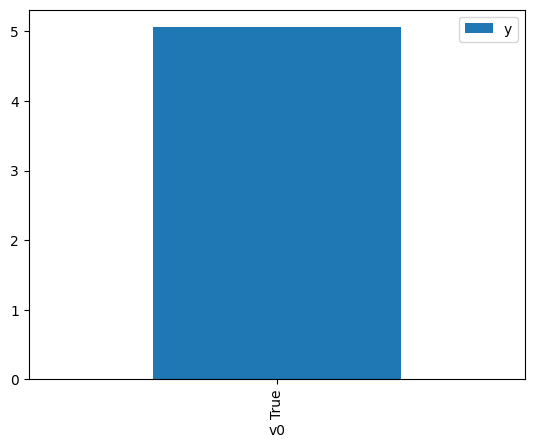

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.054317,False,0.447500,0.454250,2.201429
1,1.362178,False,0.262972,0.471207,2.122210
2,0.762659,False,1.897983,0.463423,2.157854
3,-0.279565,False,-0.282753,0.449937,2.222534
4,0.092033,False,0.145689,0.454738,2.199068
...,...,...,...,...,...
995,1.176980,False,-0.428686,0.468801,2.133102
996,-1.402948,False,0.802615,0.435483,2.296302
997,0.607079,False,-1.014821,0.461406,2.167287
998,0.039346,False,-1.275991,0.454057,2.202368


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.778195,True,5.255665,0.523384,1.910644
1,-0.393748,True,5.676380,0.551537,1.813117
2,0.497911,True,3.312709,0.540008,1.851823
3,0.832544,True,4.724325,0.535670,1.866821
4,0.736340,True,5.152573,0.536918,1.862482
...,...,...,...,...,...
995,0.396982,True,5.189197,0.541316,1.847351
996,1.288049,True,4.350782,0.529756,1.887660
997,1.413941,True,4.289907,0.528120,1.893508
998,1.032728,True,4.761474,0.533072,1.875918


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              6966.
Date:                Thu, 16 Nov 2023   Prob (F-statistic):                        0.00
Time:                        14:48:18   Log-Likelihood:                         -1405.6
No. Observations:                1000   AIC:                                      2815.
Df Residuals:                     998   BIC:                                      2825.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0246      0.028      0.876      0.381      -0.030       0.080
x2             5.0139      0.047    106.744      0.000       4.922       5.106
==============================================================================
Omnibus:                        0.124   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.940   Jarque-Bera (JB):                0.069
Skew:                           0.014   Prob(JB):                        0.966
Kurtosis:                       3.029   Cond. No.                         2.01
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""